# EAF Coffea-Casa Benchmark Example 5 - Gateway and HTCondor

In [1]:
import numpy as np
%matplotlib inline
from coffea import hist
import coffea.processor as processor
import awkward as ak
from coffea.nanoevents import schemas

In [2]:
# This program will plot the MET for events which have an opposite-sign muon pair that has mass in the range of 60-120 GeV.

class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        muon_axis = hist.Bin("MET", "MET [GeV]", 50, 1, 100)
        
        self._accumulator = processor.dict_accumulator({
            'MET': hist.Hist("Counts", dataset_axis, muon_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata["dataset"]
        
        muons = events.Muon
        MET = events.MET.pt
        
        output['cutflow']['all events'] += ak.size(muons, axis=0)
        output['cutflow']['all muons'] += ak.sum(ak.num(muons, axis=1))
        
        # Get all combinations of muon pairs in every event.
        dimuons = ak.combinations(muons, 2, fields=['i0', 'i1'])
        
        # Check that pairs have opposite charge.
        opposites = (dimuons['i0'].charge != dimuons['i1'].charge)
        
        # Get only muons with mass between 60 and 120. Add the dimuon p4's, take mass.
        limits = ((dimuons['i0'] + dimuons['i1']).mass >= 60) & ((dimuons['i0'] + dimuons['i1']).mass < 120)
        
        # Mask the dimuons with the opposites and the limits to get dimuons with opposite charge 
        #and mass between 60 and 120 GeV.
        good_dimuons = dimuons[opposites & limits]
        
        # Mask the MET to get it only if an associated dimuon pair meeting the conditions exists.
        good_MET = MET[ak.num(good_dimuons, axis=1) >= 1]
        
        output['cutflow']['final events'] += ak.size(good_MET, axis=0)
        
        output['MET'].fill(dataset=dataset, MET=good_MET)
        
        return output

    def postprocess(self, accumulator):
        return accumulator

# Connecting to the gateway
The code in the following cell imports the LPCGateway and connects to a cluster of HTCondor workers.
* gateway.new_cluster() starts a new cluster
* cluster.scale(N) specifies the number of workers in the cluster, here there are N workes in the cluster
* cluster.get_client() obtains the client that will connect your cluster to the scheduler, this is how the HTCondor workers are assigned to your tasks on the grid

In [3]:
from lpcdaskgateway import LPCGateway

gateway = LPCGateway()
cluster = gateway.new_cluster()
cluster

# Scale my cluster to 5 HTCondor workers
cluster.scale(5)

# Obtain a client for connecting to your cluster scheduler
# Your cluster should be ready to take requests
client = cluster.get_client()
client

INFO:lpcdaskgateway.LPCGateway: Creating LPCGatewayCluster 
INFO:lpcdaskgateway.GatewayCluster: Scaling: 5 HTCondor workers
INFO:lpcdaskgateway.GatewayCluster: Sandbox: /uscmst1b_scratch/lpc1/3DayLifetime/elisec/dask-gateway.0c3b04c1f911423ab59ba12e8d3f35d0
INFO:lpcdaskgateway.GatewayCluster: Success! submitted HTCondor jobs to lpcschedd2.fnal.gov with  ClusterId 37113556


Client Scheduler: gateway://172.30.227.32:80/dask-gateway.0c3b04c1f911423ab59ba12e8d3f35d0 Dashboard: https://dask-gateway.fnal.gov/clusters/dask-gateway.0c3b04c1f911423ab59ba12e8d3f35d0/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Warning: running on HTCondor could take some time
The scheduler has to have available workers to connect to your cluster, this is what takes some time. After they connect, it should be much faster.

In [4]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

executor = processor.DaskExecutor(client=client)

run = processor.Runner(executor=executor,
                        schema=schemas.NanoAODSchema,
                        savemetrics=True
                      )

output, metrics = run(fileset, "Events", processor_instance=Processor())

metrics

INFO:numexpr.utils:Note: NumExpr detected 22 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
[                                        ] | 0% Completed |  0.0s

/opt/conda/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


{'bytesread': 2802762505,
 'columns': ['nMuon',
  'Muon_mass',
  'MET_pt',
  'Muon_charge',
  'Muon_eta',
  'Muon_pt',
  'Muon_phi'],
 'entries': 53446198,
 'processtime': 714.8236541748047,
 'chunks': 534}

<AxesSubplot:xlabel='MET [GeV]', ylabel='Counts'>

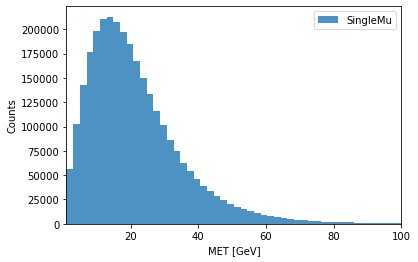

In [5]:
hist.plot1d(output['MET'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [6]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
all muons 74439173
final events 2970884


### Do not forget to shutdown your cluster
cluster.shutdown() does that gracefully

In [7]:
cluster.shutdown()

INFO:lpcdaskgateway.GatewayCluster: Shutting down HTCondor worker jobs
INFO:lpcdaskgateway.GatewayCluster: All jobs in cluster 37113556 have been marked for removal
